In [1]:
contrastive_batch_size = 7
embedding_size = 128
img_size = 224
batch_size = 16
num_classes = 2

base_path = '/home/u5169119/PatchCL-MedSeg-jiyu'
dataset_path = '/home/u5169119/dataset/0_data_dataset_voc_950_kidney'
output_dir = base_path + '/dataset/splits/kidney'
ContrastieWeights = 0.1
save_interval = 10  # 每 10 輪儲存一次

parameter = f'Resnet18_Image-{img_size}_patchSize-{contrastive_batch_size}_ContrastieWeights-{ContrastieWeights}'
supervised_loss_path = f'{base_path}/output/supervised pre training_loss-{parameter}.csv'
SSL_loss_path = f'{base_path}/output/SSL_loss-{parameter}.csv'
save_model_path = f'{base_path}/output/best_contrast-{parameter}'

voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

In [2]:
import os
import sys
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import math
import time
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

sys.path.append(base_path)

from utils.transform import Transform
from utils.stochastic_approx import StochasticApprox
from utils.model import Network
from utils.datasets_PASCAL_findContours import PascalVOCDataset
# from utils.datasets_PASCAL import PascalVOCDataset
from utils.queues import Embedding_Queues
from utils.CELOSS import CE_loss
# from utils.BCELoss import CustomCELoss
from utils.patch_utils import _get_patches
from utils.aug_utils import batch_augment
from utils.get_embds import get_embeddings
from utils.const_reg import consistency_cost
from utils.plg_loss import PCGJCL
from utils.torch_poly_lr_decay import PolynomialLRDecay
from utils.loss_file import save_loss
from utils.performance import calculate_metrics

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# cross_entropy_loss = CustomCELoss()
cross_entropy_loss=CE_loss(num_classes, image_size=img_size)

In [4]:
transform = Transform(img_size, num_classes)
embd_queues = Embedding_Queues(num_classes)
stochastic_approx = StochasticApprox(num_classes,0.5,0.8)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [5]:
model = Network(num_classes, embedding_size=embedding_size)
teacher_model = Network(num_classes, embedding_size=embedding_size)

#Turning off gradients for teacher model
for param in teacher_model.parameters():
    param.requires_grad=False
    #Esuring mothe the models have same weight
teacher_model.load_state_dict(model.state_dict())
model.contrast=False
teacher_model.contrast = False

model = nn.DataParallel(model)
model = model.to(dev)
teacher_model = nn.DataParallel(teacher_model)
teacher_model=teacher_model.to(dev)

In [6]:
from torchsummary import summary
model.eval()
summary(model, (3, img_size, img_size), batch_size, 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
            Conv2d-2         [16, 64, 112, 112]           9,408
       BatchNorm2d-3         [16, 64, 112, 112]             128
       BatchNorm2d-4         [16, 64, 112, 112]             128
              ReLU-5         [16, 64, 112, 112]               0
              ReLU-6         [16, 64, 112, 112]               0
         MaxPool2d-7           [16, 64, 56, 56]               0
         MaxPool2d-8           [16, 64, 56, 56]               0
            Conv2d-9           [16, 64, 56, 56]          36,864
           Conv2d-10           [16, 64, 56, 56]          36,864
      BatchNorm2d-11           [16, 64, 56, 56]             128
      BatchNorm2d-12           [16, 64, 56, 56]             128
             ReLU-13           [16, 64, 56, 56]               0
             ReLU-14           [16, 64,

In [7]:
metrics=[smp.utils.metrics.IoU(threshold=0.5)]

optimizer_pretrain=torch.optim.Adam(model.parameters(),lr=0.001)
optimizer_ssl=torch.optim.SGD(model.parameters(),lr=0.007)
scheduler = PolynomialLRDecay(optimizer=optimizer_pretrain, max_decay_steps=200, end_learning_rate=0.0001, power=2.0)

In [8]:
labeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/labeled.txt", image_size=img_size, root_dir=dataset_path, labeled=True, colormap=voc_mask_color_map)
labeled_dataset_length = len(labeled_dataset)

# 設定 train 和 val 的比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
# 計算 train 和 val 的長度
train_length = int(train_ratio * labeled_dataset_length)
val_length = labeled_dataset_length - train_length

train_dataset, val_dataset = random_split(labeled_dataset, [train_length, val_length])
unlabeled_dataset = PascalVOCDataset(txt_file=output_dir + "/1-3/unlabeled.txt", image_size=img_size, root_dir=dataset_path, labeled=False, colormap=voc_mask_color_map)

# 創建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# 打印資料集的大小
print('number of train_dataset: ', len(train_dataset))
print('number of val_dataset: ', len(val_dataset))
print('number of unlabeled_dataset: ', len(unlabeled_dataset))

number of train_dataset:  228
number of val_dataset:  57
number of unlabeled_dataset:  570


In [9]:
for imgs, masks in train_loader:
    break

imgs range: min=0.0, max=0.8784313797950745
masks(backbround) pixel counts: {0: 7514, 1: 42662}
masks(target) pixel counts: {0: 7514, 1: 42662}


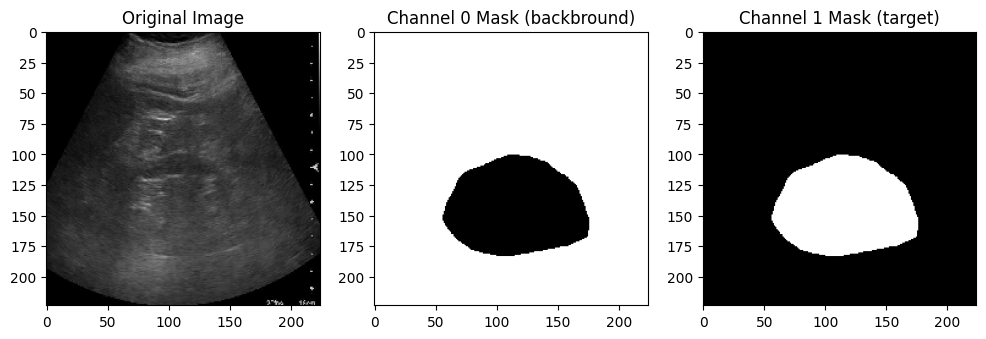

In [10]:
# 檢查一個樣本中的唯一值和像素計數
imgs_np = imgs[0, 0].numpy()
print(f"imgs range: min={imgs_np.min().item()}, max={imgs_np.max().item()}")

backbround_masks_np = masks[0, 0].numpy()
unique, counts = np.unique(backbround_masks_np, return_counts=True)
pixel_counts = dict(zip(unique, counts))
print("masks(backbround) pixel counts:", pixel_counts)

target_masks_np = masks[0, 0].numpy()
unique, counts = np.unique(target_masks_np, return_counts=True)
pixel_counts = dict(zip(unique, counts))
print("masks(target) pixel counts:", pixel_counts)

# 顯示原圖和多通道遮罩
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(imgs_np, cmap='gray')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(masks[0, 0].numpy(), cmap='gray')
plt.title("Channel 0 Mask (backbround)")

plt.subplot(1, 3, 3)
plt.imshow(masks[0, 1].numpy(), cmap='gray')
plt.title("Channel 1 Mask (target)")
plt.show()

In [11]:
#Send psudo masks & imgs to cpu
p_masks = masks

print(imgs.shape)

#get classwise patch list
patch_list = _get_patches(imgs, p_masks,classes=num_classes,background=False,img_size=img_size,patch_size=contrastive_batch_size)

#stochastic approximation filtering and threshold update
#qualified_patch_list = stochastic_approx.update(patch_list)
qualified_patch_list = patch_list

#make augmentations for teacher model
augmented_patch_list = batch_augment(qualified_patch_list,contrastive_batch_size)

#convert to tensor
aug_tensor_patch_list=[]
qualified_tensor_patch_list=[]
for i in range(len(augmented_patch_list)):
    if augmented_patch_list[i] is not None:
        aug_tensor_patch_list.append(torch.tensor(augmented_patch_list[i]))
        qualified_tensor_patch_list.append(torch.tensor(qualified_patch_list[i]))
    else:
        aug_tensor_patch_list.append(None)
        qualified_tensor_patch_list.append(None)

torch.Size([16, 3, 224, 224])


In [12]:
def print_and_visualize_masks_outputs(masks, output, threshold=0.5):
    """
    打印和可視化 mask 和 output 的信息。
    
    參數:
    masks: 實際的掩碼，形狀為 (batch_size, num_classes, height, width)
    output: 模型的輸出，形狀為 (batch_size, num_classes, height, width)
    threshold: 二值化的閾值
    """
    # 打印形狀和數值範圍
    print(f"Masks shape: {masks.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Masks value range: min={masks.min().item()}, max={masks.max().item()}")
    print(f"Output value range: min={output.min().item()}, max={output.max().item()}")
    
    # 將輸出進行二值化
    binary_output = (output > threshold).float()
    print(f"Binary output value range: min={binary_output.min().item()}, max={binary_output.max().item()}")
    
    # 可視化部分樣本
    for i in range(min(3, output.size(0))):
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        axes[0].imshow(masks[i, 0].cpu().numpy(), cmap='gray')
        axes[0].set_title('Mask (channel 0)')
        
        axes[1].imshow(masks[i, 1].cpu().numpy(), cmap='gray')
        axes[1].set_title('Mask (channel 1)')
        
        axes[2].imshow(binary_output[i, 0].cpu().numpy(), cmap='gray')
        axes[2].set_title('Binary Output (channel 0)')
        
        axes[3].imshow(binary_output[i, 1].cpu().numpy(), cmap='gray')
        axes[3].set_title('Binary Output (channel 1)')
        
        plt.show()

student_emb_list len:  2
teacher_embedding_list len:  2
PCGJCL_loss:  tensor([8.2488], device='cuda:0', grad_fn=<ToCopyBackward0>)
masks shape:  torch.Size([16, 2, 224, 224])
output shape:  torch.Size([16, 2, 224, 224])
Masks shape: torch.Size([16, 2, 224, 224])
Output shape: torch.Size([16, 2, 224, 224])
Masks value range: min=0, max=1
Output value range: min=-2.2534141540527344, max=1.9539310932159424
Binary output value range: min=0.0, max=1.0


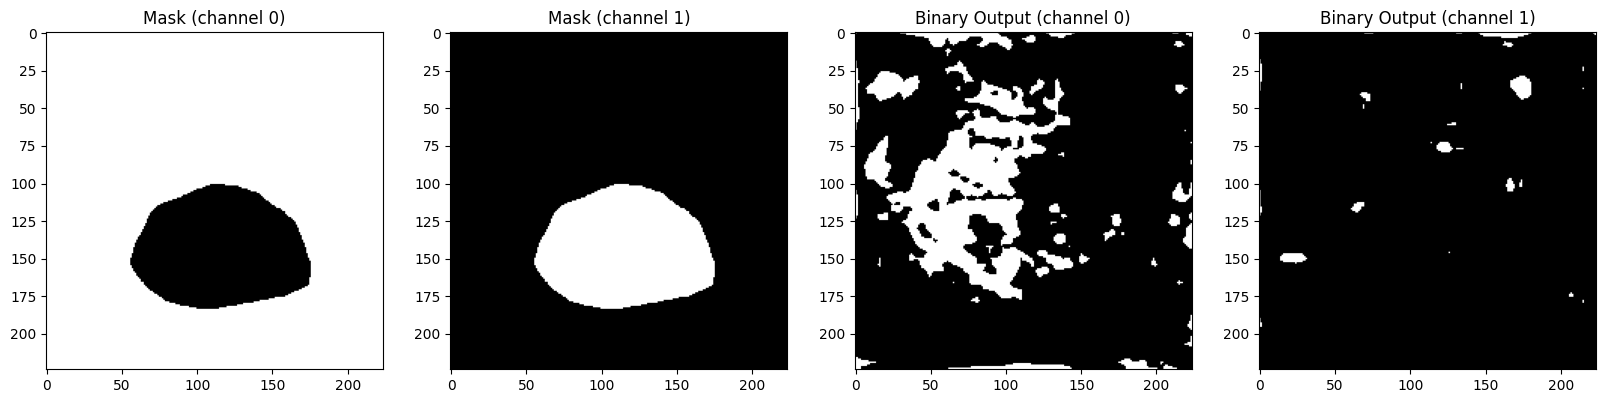

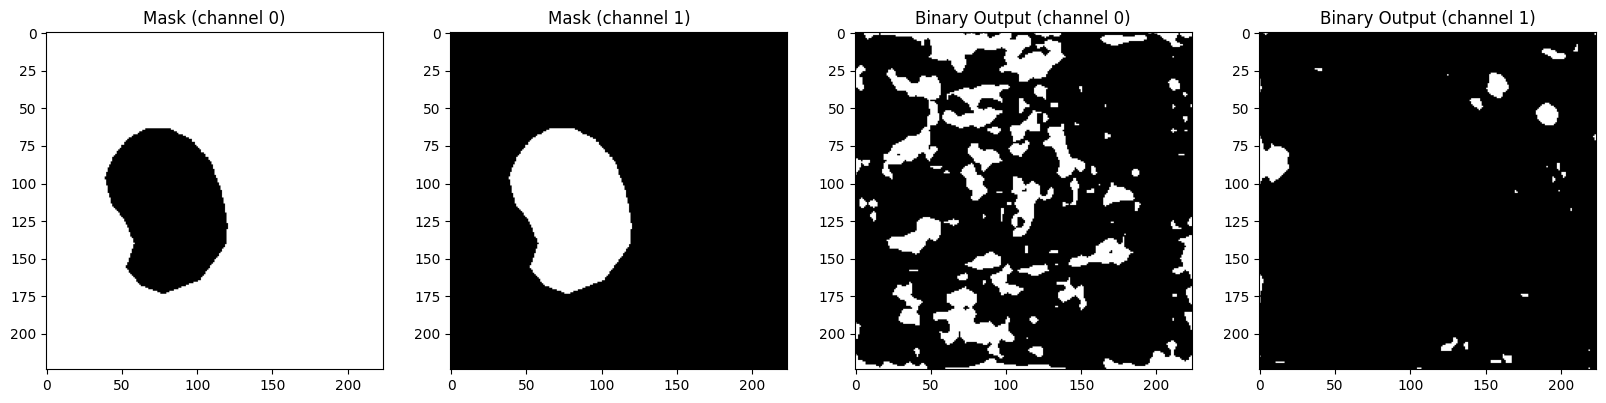

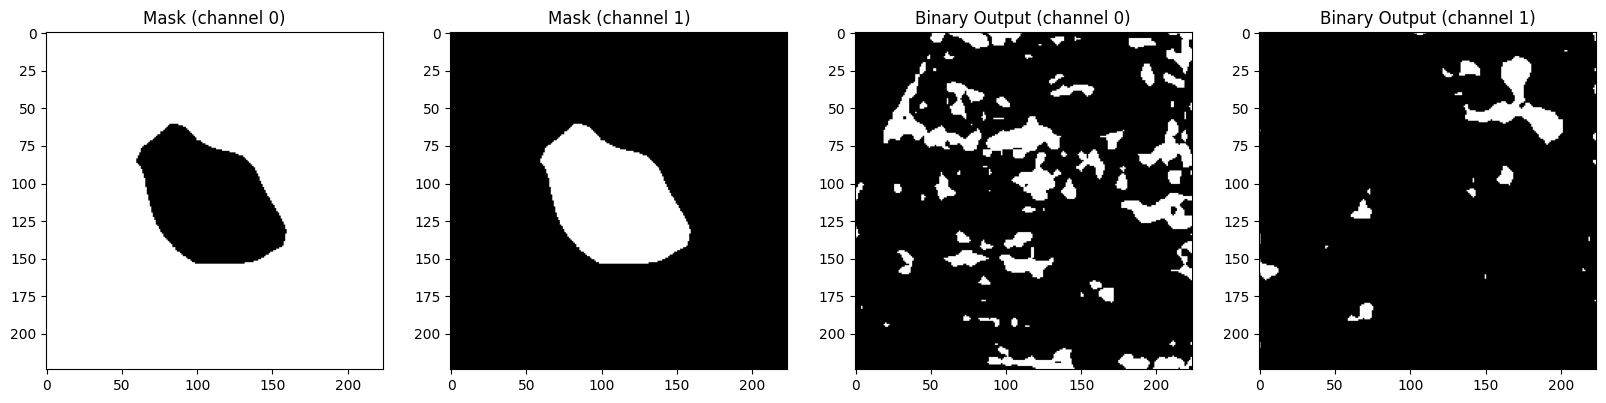

Output value range: min=-2.2534141540527344, max=1.9539310932159424
supervised_loss:  tensor(0.6301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
mIoU: 1.0485870505227979e-10, Accuracy: 0.5, Dice: 1.0485870505227979e-10


In [13]:
#get embeddings of qualified patches through student model
model=model.train()
model.module.contrast=True
student_emb_list = get_embeddings(model,qualified_tensor_patch_list,True)
print('student_emb_list len: ', len(student_emb_list))


#get embeddings of augmented patches through teacher model
teacher_model.train()
teacher_model.module.contrast = True
teacher_embedding_list = get_embeddings(teacher_model,aug_tensor_patch_list,False)
print('teacher_embedding_list len: ', len(teacher_embedding_list))

#enqueue these
embd_queues.enqueue(teacher_embedding_list)

#calculate PCGJCL loss
PCGJCL_loss = PCGJCL(student_emb_list, embd_queues, embedding_size, 0.2 , 4, psi=4096)
PCGJCL_loss = PCGJCL_loss.to(dev)
print('PCGJCL_loss: ', PCGJCL_loss)

model.module.contrast=False
#calculate supervied loss
imgs, masks =imgs.to(dev), masks.to(dev)
out = model(imgs)
print('masks shape: ', masks.shape)
print('output shape: ', out.shape)
print_and_visualize_masks_outputs(masks, out)

min_val, max_val = torch.min(out).item(), torch.max(out).item()
print(f"Output value range: min={min_val}, max={max_val}")

supervised_loss = cross_entropy_loss(out,masks)
supervised_loss = supervised_loss.to(dev)
print('supervised_loss: ', supervised_loss)

miou, accuracy, dice = calculate_metrics(out, masks, num_classes)
print(f"mIoU: {miou}, Accuracy: {accuracy}, Dice: {dice}")

#total loss
loss = supervised_loss + ContrastieWeights*PCGJCL_loss

In [14]:
def reset_bn_stats(model, train_loader):
    model.train()
    with torch.no_grad():
        for imgs, _ in train_loader:
            imgs = imgs.to(dev)
            _ = model(imgs)

In [15]:
def validate(model, val_loader, criterion, num_classes):
    model.eval()  # 設置模型為評估模式
    model.module.contrast = False
    val_loss = 0.0
    val_miou = 0.0
    val_accuracy = 0.0
    val_dice = 0.0
    total_samples = 0

    with torch.no_grad():  # 禁用梯度計算
        for imgs, masks in val_loader:
            imgs = imgs.to(dev)
            masks = masks.to(dev)
            
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            miou, accuracy, dice = calculate_metrics(outputs, masks, num_classes)
            val_loss += loss.item() * imgs.size(0)
            val_miou += miou * imgs.size(0)
            val_accuracy += accuracy * imgs.size(0)
            val_dice += dice * imgs.size(0)
            total_samples += imgs.size(0)
            print(f"Validation - outputs: min {outputs.min().item()}, max {outputs.max().item()}, mean {outputs.mean().item()}")

            print(f"Validation - loss: {loss.item()}, mIoU: {miou}, Accuracy: {accuracy}, Dice: {dice}")

    val_loss /= total_samples
    val_miou /= total_samples
    val_accuracy /= total_samples
    val_dice /= total_samples

    return val_loss, val_miou, val_accuracy, val_dice

In [16]:
for c_epochs in range(100): #100 epochs supervised pre training
    step=0
    min_loss = math.inf
    epoch_t_loss=0
    print('Epoch ',c_epochs)
    
    total_t_supervised_loss = 0
    total_t_contrastive_loss = 0 
    total_t_miou = 0 
    total_t_accuracy = 0 
    total_t_dice = 0 
    
    for imgs, masks in train_loader:
        optimizer_pretrain.zero_grad()
        
        t1=time.time()
        with torch.no_grad():

            #Send psudo masks & imgs to cpu
            p_masks = masks
            imgs = imgs

            #get classwise patch list
            patch_list = _get_patches(
                imgs, p_masks,
                classes=num_classes,
                background=True,
                img_size=img_size,
                patch_size=contrastive_batch_size
            )

            #stochastic approximation filtering and threshold update
            #qualified_patch_list = stochastic_approx.update(patch_list)
            qualified_patch_list = patch_list

            #make augmentations for teacher model
            augmented_patch_list = batch_augment(qualified_patch_list,contrastive_batch_size)


            #convert to tensor
            aug_tensor_patch_list=[]
            qualified_tensor_patch_list=[]
            for i in range(len(augmented_patch_list)):
                if augmented_patch_list[i] is not None:
                    aug_tensor_patch_list.append(torch.tensor(augmented_patch_list[i]))
                    qualified_tensor_patch_list.append(torch.tensor(qualified_patch_list[i]))
                else:
                    aug_tensor_patch_list.append(None)
                    qualified_tensor_patch_list.append(None)


        #get embeddings of qualified patches through student model
        model=model.train()
        model.module.contrast=True
        student_emb_list = get_embeddings(model,qualified_tensor_patch_list,True)

        #get embeddings of augmented patches through teacher model
        teacher_model.train()
        teacher_model.contrast = True
        teacher_embedding_list = get_embeddings(teacher_model,aug_tensor_patch_list,False)

        #enqueue these
        embd_queues.enqueue(teacher_embedding_list)

        #calculate PCGJCL loss
        PCGJCL_loss = PCGJCL(student_emb_list, embd_queues, embedding_size, 0.2 , 4, psi=4096)        
        print('PCGJCL_loss: ', PCGJCL_loss.item())
        
        #calculate supervied loss
        imgs, masks =imgs.to(dev), masks.to(dev)
        model.module.contrast=False
        out = model(imgs)
        
        supervised_loss = cross_entropy_loss(out,masks)
        print('supervised_loss: ', supervised_loss.item())
        miou, accuracy, dice = calculate_metrics(out, masks, num_classes)
        print(f"mIoU: {miou}, Accuracy: {accuracy}, Dice: {dice}")
        print(f"Training - outputs: min {out.min().item()}, max {out.max().item()}, mean {out.mean().item()}")

        #total loss
        PCGJCL_loss = PCGJCL_loss.to(dev)
        loss = supervised_loss + ContrastieWeights*PCGJCL_loss
        
        total_t_contrastive_loss += PCGJCL_loss.item()
        total_t_supervised_loss += supervised_loss.item()
        epoch_t_loss+=loss.item()
        
        total_t_miou += miou 
        total_t_accuracy += accuracy 
        total_t_dice += dice 

        #backpropagate
        loss.backward()
        optimizer_pretrain.step()

        for param_stud, param_teach in zip(model.parameters(),teacher_model.parameters()):
            param_teach.data.copy_(0.001*param_stud + 0.999*param_teach)

        #Extras
        t2=time.time()
        print('step ', step, 'loss: ',loss, ' & time: ',t2-t1)
        step+=1  
    
    avg_t_epoch_loss = epoch_t_loss / len(train_loader)
    avg_t_supervised_loss = total_t_supervised_loss / len(train_loader)
    avg_t_contrastive_loss = total_t_contrastive_loss / len(train_loader)
    avg_t_miou = total_t_miou / len(train_loader)
    avg_t_accuracy = total_t_accuracy / len(train_loader)
    avg_t_dice = total_t_dice / len(train_loader)
    
    reset_bn_stats(model, train_loader)
    val_loss, val_miou, val_accuracy, val_dice = validate(model, val_loader, cross_entropy_loss, num_classes)

    save_loss(
        t_total_loss = f"{avg_t_epoch_loss:.4f}", 
        t_supervised_loss=f"{avg_t_supervised_loss:.4f}", 
        t_contrastive_loss=f"{avg_t_contrastive_loss:.4f}", 
        t_miou = f"{avg_t_miou:.4f}",    
        t_accuracy = f"{avg_t_accuracy:.4f}",
        t_dice = f"{avg_t_dice:.4f}",
        t_consistency_loss = 0 ,
        v_total_loss = f"{val_loss:.4f}", 
        v_supervised_loss = f"{val_loss:.4f}", 
        v_miou = f"{val_miou:.4f}",    
        v_accuracy = f"{val_accuracy:.4f}",
        v_dice = f"{val_dice:.4f}",
        v_contrastive_loss=0, 
        v_consistency_loss=0, 
        filename=supervised_loss_path
    )
    
    if (c_epochs + 1) % save_interval == 0:
        torch.save(model,f'{save_model_path}_s_epoch{c_epochs}.pth')
        torch.save(teacher_model,f'{save_model_path}_t_epoch{c_epochs}.pth')

Epoch  0
PCGJCL_loss:  8.182318687438965
supervised_loss:  0.6422904133796692
mIoU: 9.539938283786853e-11, Accuracy: 0.49999937415122986, Dice: 9.539938283786853e-11
Training - outputs: min -2.3186089992523193, max 2.034717559814453, mean 0.07541819661855698
step  0 loss:  tensor([1.4605], device='cuda:0', grad_fn=<AddBackward0>)  & time:  44.44432711601257
PCGJCL_loss:  10.573803901672363
supervised_loss:  0.48829805850982666
mIoU: 9.064063306141179e-06, Accuracy: 0.5000087022781372, Dice: 1.812540358514525e-05
Training - outputs: min -2.0055203437805176, max 2.507378101348877, mean 0.07328253984451294


KeyboardInterrupt: 

In [ ]:
for imgs in unlabeled_loader:
    break

In [ ]:
for c_epochs in range(200): #200 epochs supervised SSL
    step=0
    min_loss = math.inf
    epoch_t_loss=0
    print('Epoch ',c_epochs)
    
    total_t_supervised_loss = 0
    total_t_contrastive_loss = 0 
    total_t_consistency_loss = 0 
    total_t_miou = 0 
    total_t_accuracy = 0 
    total_t_dice = 0 

    train_iterator = iter(train_loader)
    
    for imgs in unlabeled_loader:
        optimizer_ssl.zero_grad()
        
        t1=time.time()
        with torch.no_grad():

            #send imgs to dev
            imgs = imgs.to(dev)

            #set model in Eval mode
            model = model.eval()

            #Get pseudo masks
            model.module.contrast=False
            p_masks = model(imgs)

            #Send psudo masks & imgs to cpu
            p_masks = masks
            p_masks = p_masks.to('cpu').detach()
            imgs = imgs.to('cpu').detach()

            try:
                imgs2, masks2 = next(train_iterator)
            except StopIteration:
                train_iterator = iter(train_loader)
                imgs2, masks2 = next(train_iterator)

            #concatenating unlabeled and labeled sets
            p_masks = torch.cat([p_masks,masks2],dim=0)
            imgs = torch.cat([imgs,imgs2],dim=0)
            
            #get classwise patch list
            patch_list = _get_patches(
                imgs, p_masks,
                classes=num_classes,
                background=True,
                img_size=img_size,
                patch_size=contrastive_batch_size
            )

            #stochastic approximation filtering and threshold update
            qualified_patch_list = stochastic_approx.update(patch_list)


            #make augmentations for teacher model
            augmented_patch_list = batch_augment(qualified_patch_list,contrastive_batch_size)

            #convert to tensor
            aug_tensor_patch_list=[]
            qualified_tensor_patch_list=[]
            for i in range(len(augmented_patch_list)):
                if augmented_patch_list[i] is not None:
                    aug_tensor_patch_list.append(torch.tensor(augmented_patch_list[i]))
                    qualified_tensor_patch_list.append(torch.tensor(qualified_patch_list[i]))
                else:
                    aug_tensor_patch_list.append(None)
                    qualified_tensor_patch_list.append(None)

        #get embeddings of qualified patches through student model
        model=model.train()
        model.module.contrast=True
        student_emb_list = get_embeddings(model,qualified_tensor_patch_list,True)

        #get embeddings of augmented patches through teacher model
        teacher_model.train()
        teacher_model.module.contrast = True
        teacher_embedding_list = get_embeddings(teacher_model,aug_tensor_patch_list,False)

        #enqueue these
        embd_queues.enqueue(teacher_embedding_list)
        PCGJCL_loss = PCGJCL(student_emb_list, embd_queues, embedding_size, 0.2 , 4, psi=4096) 

        #calculate supervied loss
        imgs2, p_masks =imgs2.to(dev), p_masks.to(dev)
        
        model.module.contrast = False
        out = model(imgs)
        supervised_loss = cross_entropy_loss(out,p_masks)
        
        teacher_model.module.contrast = False
        #Consistency Loss
        consistency_loss=consistency_cost(model,teacher_model,imgs,p_masks)
        
        supervised_loss = supervised_loss.to(dev)
        PCGJCL_loss = PCGJCL_loss.to(dev)
        consistency_loss = consistency_loss.to(dev)
        
        miou, accuracy, dice = calculate_metrics(out, p_masks, num_classes)
        print(f"mIoU: {miou}, Accuracy: {accuracy}, Dice: {dice}")
        
        total_t_supervised_loss += supervised_loss.item()
        total_t_contrastive_loss += PCGJCL_loss.item()
        total_t_consistency_loss += consistency_loss.item() 
        
        total_t_miou += miou 
        total_t_accuracy += accuracy 
        total_t_dice += dice 
        
        print("supervised_loss: ", supervised_loss.item())
        print("PCGJCL_loss: ", PCGJCL_loss.item())
        print("consistency_loss: ", consistency_loss.item())
        
        #total loss
        loss = supervised_loss + ContrastieWeights*PCGJCL_loss + 4*consistency_loss
        epoch_t_loss += loss.item()
        
        #backpropagate
        loss.backward()
        optimizer_ssl.step()
        scheduler.step()


        for param_stud, param_teach in zip(model.parameters(),teacher_model.parameters()):
            param_teach.data.copy_(0.001*param_stud + 0.999*param_teach)

        #Extras
        t2=time.time()
        print('step ', step, 'loss: ',loss, ' & time: ',t2-t1)
        step+=1
        
    avg_t_epoch_loss = epoch_t_loss / len(train_loader)
    avg_t_supervised_loss = total_t_supervised_loss / len(train_loader)
    avg_t_contrastive_loss = total_t_contrastive_loss / len(train_loader)
    avg_consistency_loss = total_t_consistency_loss / len(train_loader)
    avg_t_miou = total_t_miou / len(train_loader)
    avg_t_accuracy = total_t_accuracy / len(train_loader)
    avg_t_dice = total_t_dice / len(train_loader)
    
    reset_bn_stats(model, train_loader)
    val_loss, val_miou, val_accuracy, val_dice = validate(model, val_loader, cross_entropy_loss, num_classes)

    save_loss(
        t_total_loss = f"{avg_t_epoch_loss:.4f}", 
        t_supervised_loss=f"{avg_t_supervised_loss:.4f}", 
        t_contrastive_loss=f"{avg_t_contrastive_loss:.4f}", 
        t_miou = f"{avg_t_miou:.4f}",    
        t_accuracy = f"{avg_t_accuracy:.4f}",
        t_dice = f"{avg_t_dice:.4f}",
        t_consistency_loss = f"{avg_consistency_loss:.4f}" ,
        v_total_loss = f"{val_loss:.4f}", 
        v_supervised_loss = f"{val_loss:.4f}", 
        v_miou = f"{val_miou:.4f}",    
        v_accuracy = f"{val_accuracy:.4f}",
        v_dice = f"{val_dice:.4f}",
        v_contrastive_loss=0, 
        v_consistency_loss=0, 
        filename=SSL_loss_path
     )
    
    if (c_epochs + 1) % save_interval == 0:
        torch.save(model,f'{save_model_path}_s_epoch{c_epochs}_SSL.pth')
        torch.save(teacher_model,f'{save_model_path}_t_epoch{c_epochs}_SSL.pth')